# Homework 3: Visualizing Data with Movies

Name: <font color='blue'> Alan Tam

Date: <font color='blue'> 02/04/2025

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [1]:
# import modules here
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc4
import moviepy.video.io.ImageSequenceClip

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [2]:
# define the path to the data folder
data_folder = '/Users/kouryl/SJSU/cs185c/data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [3]:
# read in the data
data_file = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','SST.nc', 'SST_20150101.nc')
ds = xr.open_dataset(data_file, decode_times=False)
longitude = np.array(ds['LONGITUDE_T'][:])
latitude = np.array(ds['LATITUDE_T'][:])
sst = np.array(ds['SST'])
ds.close()

Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [4]:
# define the longitude/latitude bounds
min_lon = -170
max_lon = -110
min_lat = 25
max_lat = 75

# compute the min/max row/col in the data grid
min_row = np.argmin(np.abs(latitude - min_lat))
max_row = np.argmin(np.abs(latitude - max_lat))
min_col = np.argmin(np.abs(longitude - min_lon))
max_col = np.argmin(np.abs(longitude - max_lon))
print(f'min_row:{min_row}, max_row:{max_row}\nmin_col:{min_col}, max_col:{max_col}')

min_row:459, max_row:659
min_col:39, max_col:279


Use the row and column bounds to subset the longitude, latitude, and your variable:

In [5]:
# subset the data
sst_subset = sst[0, min_row:max_row, min_col:max_col]
longitude_subset = longitude[min_col:max_col]
latitude_subset = latitude[min_row:max_row]
#ds

Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

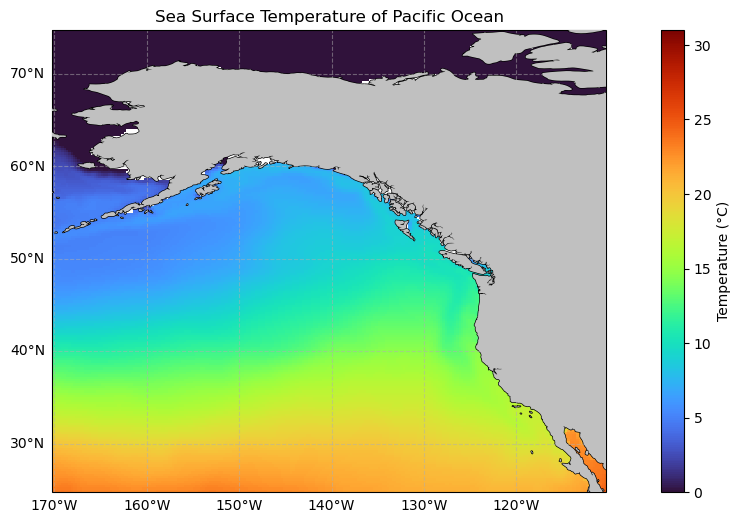

In [6]:
# make your figure here
fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(longitude_subset, latitude_subset, sst_subset, cmap='turbo', vmin=0, vmax=31)
plt.colorbar(orientation = 'vertical', label='Temperature (°C)')
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()

# Add latitude and longitude grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
gl.top_labels = False  # Disable top labels
gl.right_labels = False

plt.title('Sea Surface Temperature of Pacific Ocean')
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [7]:
def plot_panel(year,month,day):
    # read data
    plt.close('all')
    data_file = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','SST.nc', f'SST_{year}{month:02d}{day:02d}.nc')
    
    ds = xr.open_dataset(data_file, decode_times=False)
    longitude = np.array(ds['LONGITUDE_T'][:])
    latitude = np.array(ds['LATITUDE_T'][:])
    sst = np.array(ds['SST'][:])
    ds.close()

    sst_subset = sst[0, min_row:max_row, min_col:max_col]
    longitude_subset = longitude[min_col:max_col]
    latitude_subset = latitude[min_row:max_row]
    
    # plot function here
    fig = plt.figure(figsize=(14,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # plot the sea 
    plt.pcolormesh(longitude_subset, latitude_subset, sst_subset, vmin=0, vmax=31, cmap='turbo')
    plt.colorbar(orientation = 'vertical', label='Temperature (°C)')
    plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
    plt.gca().coastlines()
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False
    
    # title
    plt.title(f'Sea Surface Temperature {month:02d}-{day:02d}-{year}')
    
    # save the figure
    plt.savefig(f'/Users/kouryl/SJSU/cs185c/homework/homework_3/panels/SST_{year}{month:02d}{day:02d}.png')
    plt.close(fig)

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [8]:
# loop through the data and make a plot for each day
year = 2015
for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        plot_panel(year,month,day)

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [9]:
# make a list of files for each movie panel
panel_directory = '/Users/kouryl/SJSU/cs185c/homework/homework_3/panels'
file_list = []

for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        file_path = os.path.join(panel_directory,f'SST_{year}{month:02d}{day:02d}.png')
        file_list.append(file_path)

#should be already sorted by the given for loop

In [10]:
# set the frames per second
fps=20

# use the ImageSequenceClip module to set up the clip
clip=moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list,fps=fps)

# write the video to a file
clip.write_videofile('Hw3.mp4')

Moviepy - Building video Hw3.mp4.
Moviepy - Writing video Hw3.mp4



Moviepy - Done !
Moviepy - video ready Hw3.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: <font color='blue'> In this movie, around May, the ocean temperature heats up in a counter clockwise rotation, which is related to the oceanographic of gyres. According to an NOAA image, the current moves east from the pacific, but near Alaska, it starts to rotate upward then west.